In [14]:
%matplotlib inline
import os
import sys
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import pickle as pk
from tqdm import tqdm
import pymaster as nmt
sys.path.append('../')
import matplotlib
import lenspyx
import camb
import emcee
import corner
from getdist import plots, MCSamples
from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [2]:
%load_ext autoreload
%autoreload 2
from delens import DelensAndCl

In [3]:
DC1 = DelensAndCl('delensing1.ini')

Simulation uses /global/cscratch1/sd/lonappan/S4BIRD/LiteBIRD/SIM_SET1/Maps
Simulation uses /global/cscratch1/sd/lonappan/S4BIRD/LiteBIRD/SIM_SET1/Maps
Delensing LiteBIRD-SET1 with LiteBIRD-SET1
Template is constructed using LiteBIRD-SET1
Delensing uses QE: p_eb
Reading coupling matrix from /global/cscratch1/sd/lonappan/S4BIRD/LiteBIRD/SIM_SET1/Pseudo/workspace/coupling_matrix_Nside512_fsky_0p8_beam_None_Apo_C1_Deg_10.fits


In [4]:
DC2 = DelensAndCl('delensing2.ini')

Simulation uses /global/cscratch1/sd/lonappan/S4BIRD/LiteBIRD/SIM_SET2/Maps
Simulation uses /global/cscratch1/sd/lonappan/S4BIRD/LiteBIRD/SIM_SET3/Maps
Delensing LiteBIRD-SET2 with LiteBIRD-SET3
Template is constructed using LiteBIRD-SET2
Delensing uses QE: p_eb
Reading coupling matrix from /global/cscratch1/sd/lonappan/S4BIRD/LiteBIRD/SIM_SET2/Pseudo/workspace/coupling_matrix_Nside512_fsky_0p8_beam_None_Apo_C1_Deg_10.fits


In [5]:
DC3 = DelensAndCl('delensing3.ini')

Simulation uses /global/cscratch1/sd/lonappan/S4BIRD/LiteBIRD/SIM_SET3/Maps
Simulation uses /global/cscratch1/sd/lonappan/S4BIRD/LiteBIRD/SIM_SET3/Maps
Delensing LiteBIRD-SET3 with LiteBIRD-SET3
Template is constructed using LiteBIRD-SET3
Delensing uses QE: p_eb
Reading coupling matrix from /global/cscratch1/sd/lonappan/S4BIRD/LiteBIRD/SIM_SET3/Pseudo/workspace/coupling_matrix_Nside512_fsky_0p8_beam_None_Apo_C1_Deg_10.fits


In [6]:
camb_ini = '/global/cscratch1/sd/lonappan/S4BIRD/CAMB/BBSims_params.ini'

In [7]:
class Delens_Theory:
    def __init__(self,ini,lmax,N0,beam=None,nlevp=0):
        pars = camb.read_ini(ini)
        pars.max_l = lmax
        self.lmax = lmax
        self.results = camb.get_results(pars)
        self.ell = np.arange(self.lmax +1)
        self.n0 = N0
        self.cl_pp = self.results.get_lens_potential_cls()[:,0]
        self.nlevp = np.radians(nlevp/60)**2
        self.fl = np.ones(self.lmax+1) if beam is None else hp.gauss_beam(np.radians(beam/60.),self.lmax,True)[:,2]
        
    @property
    def N0(self):
        N0 = np.zeros(self.lmax+1)
        N0_ = self.n0
        N0[np.arange(len(N0_))] += N0_
        return self.DL*N0
        
    @property    
    def DL(self):
        l = self.ell
        return (l*(l+1))**2 / (2*np.pi)
    @property    
    def dl(self):
        l = self.ell
        return (l*(l+1)) / (2*np.pi)    
    @property
    def cl_pp_res(self):
        return self.cl_pp*(1 - (self.cl_pp/(self.cl_pp+self.N0)))
        
    @property
    def lensed_bb(self):
        bb = np.zeros(self.lmax+1)
        bb_ = self.results.get_lensed_scalar_cls(lmax=self.lmax,CMB_unit='muK')[:,2]
        bb[np.arange(len(bb_))] += bb_
        return (bb/self.dl)
    
    @property
    def tensor_bb(self):
        bb = np.zeros(self.lmax+1)
        bb_ = self.results.get_tensor_cls(lmax=self.lmax,CMB_unit='muK')[:,2]
        bb[np.arange(len(bb_))] += bb_
        return (bb/self.dl)
    
    @property
    def delensed_bb(self):
        bb = np.zeros(self.lmax+1)
        bb_ = self.results.get_lensed_cls_with_spectrum(self.cl_pp_res,lmax=self.lmax,CMB_unit='muK')[:,2]
        bb[np.arange(len(bb_))] += bb_
        return (bb/self.dl)
    @property
    def df_bb(self):
        return self.delensed_bb - self.lensed_bb
    
    def plt_bb(self):
        plt.figure(figsize=(7,7))
        plt.loglog(self.ell,self.lensed_bb,label='Lensed')
        plt.loglog(self.ell,self.delensed_bb,label='Delensed')
        plt.legend(fontsize=20)
        plt.ylim(1e-6,None)
        plt.xlabel('$\ell$',fontsize=20)
        plt.ylabel('$C_\ell^{BB}$',fontsize=20)
        
    def plt_pp(self):
        plt.figure(figsize=(7,7))
        plt.loglog(self.ell,self.cl_pp,label='PP')
        plt.loglog(self.ell,self.cl_pp_res,label='Residual')
        plt.legend(fontsize=20)
        plt.xlabel('$\ell$',fontsize=20)
        plt.ylabel('$C_\ell^{\phi \phi}$',fontsize=20)

In [8]:
the = Delens_Theory(camb_ini,DC2.pseudocl_lib.b.lmax,DC1.delens_lib.get_N0(0),30,2.16)

In [9]:
the.plt_pp()

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


In [10]:
class MeanAndCovariance:
    
    def __init__(self,lib_dir,biased,unbiased,biased2,theory,lmin,lmax):
        self.lib_dir = lib_dir
        self.biased = biased
        self.unbiased = unbiased
        self.biased2 = biased2
        self.theory = theory
        self.ell = self.biased.pseudocl_lib.ell
        self.select = np.where((self.ell >= lmin)& (self.ell <= lmax))[0]
        self.get_biased()
        self.get_unbiased()
        self.get_biased2()
        
        os.makedirs(lib_dir,exist_ok=True)
    
    def get_biased(self,which=None):
        def creturn(dic):
            if which is None:
                pass
            else:
                return dic[which]
        
        fname = os.path.join(self.lib_dir,'biased.pkl')
        if os.path.isfile(fname):
            return creturn(pk.load(open(fname,'rb')))
        else:
            lensed = []
            delensed = []
            for i in tqdm(range(1000),desc='Biased spectra Array', unit='simulation'):
                lensed.append(self.biased.pseudocl_lib.get_lensed_cl(i))
                delensed.append(self.biased.pseudocl_lib.get_delensed_cl(i))
            dic = {'lensed':np.array(lensed),'delensed':np.array(delensed)}
            pk.dump(dic,open(fname,'wb'))
            return creturn(dic)
        
    def get_unbiased(self,which=None):
        def creturn(dic):
            if which is None:
                pass
            else:
                return dic[which]
        
        fname = os.path.join(self.lib_dir,'unbiased.pkl')
        if os.path.isfile(fname):
            return creturn(pk.load(open(fname,'rb')))
        else:
            lensed = []
            delensed = []
            for i in tqdm(range(1000),desc='Unbiased spectra Array', unit='simulation'):
                lensed.append(self.unbiased.pseudocl_lib.get_lensed_cl(i))
                delensed.append(self.unbiased.pseudocl_lib.get_delensed_cl(i))
            dic = {'lensed':np.array(lensed),'delensed':np.array(delensed)}
            pk.dump(dic,open(fname,'wb'))
            
            return creturn(dic)
        
    def get_biased2(self,which=None):
        def creturn(dic):
            if which is None:
                pass
            else:
                return dic[which]
        
        fname = os.path.join(self.lib_dir,'biased2.pkl')
        if os.path.isfile(fname):
            return creturn(pk.load(open(fname,'rb')))
        else:
            lensed = []
            delensed = []
            for i in tqdm(range(1000),desc='Biased2 spectra Array', unit='simulation'):
                lensed.append(self.biased2.pseudocl_lib.get_lensed_cl(i))
                delensed.append(self.biased2.pseudocl_lib.get_delensed_cl(i))
            dic = {'lensed':np.array(lensed),'delensed':np.array(delensed)}
            pk.dump(dic,open(fname,'wb'))
            return creturn(dic)
    
    def bias_array(self):
        biased_lensed = self.get_biased2('lensed')
        biased_delensed = self.get_biased2('delensed')
        unbiased_lensed = self.get_unbiased('lensed')
        unbiased_delensed = self.get_unbiased('delensed')
        
        df_biased = biased_delensed - biased_lensed
        df_unbiased = unbiased_delensed - unbiased_lensed
        
        return df_biased - df_unbiased
    
    def mcbias_array(self):
        lmax = self.unbiased.pseudocl_lib.b.lmax
        unbiased_lensed = self.get_unbiased('lensed')
        unbiased_delensed = self.get_unbiased('delensed')
        theory_delensed = (self.theory.delensed_bb * self.theory.fl**2) + self.theory.nlevp
        theory_lensed = (self.theory.lensed_bb * self.theory.fl**2) + self.theory.nlevp
        df_theory = self.unbiased.pseudocl_lib.b.bin_cell(theory_delensed-theory_lensed)
        df_unbiased = unbiased_delensed - unbiased_lensed
        
        return df_unbiased - df_theory
    
    def cov(self,arr):
        mean = arr.mean(axis=0)[self.select]
        ncov = len(mean)
        cov = np.zeros((ncov,ncov))
        for i in tqdm(range(1000),desc='Covariance', unit='simulation'):
            arr_i = arr[i][self.select]
            cov += arr_i[None,:]*arr_i[:,None]
        cov/=1000
        cov -= mean[None,:]*mean[:,None]
        return cov
    
    def cov_cross(self,arr1,arr2):
        mean1 = arr1.mean(axis=0)[self.select]
        mean2 = arr2.mean(axis=0)[self.select]
        ncov = len(mean1)
        cov = np.zeros((ncov,ncov))
        for i in tqdm(range(1000),desc='Covariance', unit='simulation'):
            arr1_i = arr1[i][self.select]
            arr2_i = arr2[i][self.select]
            cov += arr1_i[None,:]*arr2_i[:,None]
        cov/=1000
        cov -= mean1[None,:]*mean2[:,None]
        return cov 
    
    def lensed_cov_fid(self):
        return self.cov(self.get_biased('lensed'))
        
    
    def delensed_cov_fid(self):
        return self.cov(self.get_unbiased('delensed'))
    
    def total_variance(self):
        bias_var = np.diag(self.cov(self.bias_array())) + np.diag(self.cov(self.mcbias_array())) 
        cov = self.cov_cross(self.bias_array(),self.mcbias_array())
        totalcov = bias_var + np.diag(2*cov)
        return totalcov
    
    def delensed_cov_summed(self):
        total = self.total_variance()
        cov = self.cov(self.get_biased('delensed'))
        ncov = len(total)
        final_cov = np.zeros((ncov,ncov))
        np.fill_diagonal(final_cov,total+np.diag(cov))
        return final_cov
    
        
    def totalbias(self):
        return self.bias_array().mean(axis=0) + self.mcbias_array().mean(axis=0)
    
    def get_debiased(self):
        return self.get_biased('delensed') -self.totalbias()
    
    def get_debiased_extra(self):
        return self.get_biased('delensed') - self.bias_array() - self.mcbias_array()
    
    def delensed_cov_extra(self):
        return self.cov(self.get_debiased_extra())
        
    
    def eff(self):
        e =  1-(self.get_debiased_extra().mean(axis=0)/self.get_biased('lensed').mean(axis=0))
        return np.mean(e[self.select])
    def corr(self,mat):
        sha = mat.shape
        corr_mat = np.zeros(sha)
        for i in range(sha[0]):
            for j in range(sha[1]):
                corr_mat[i,j] = mat[i,j]/np.sqrt(mat[i,i]*mat[j,j])      
        return corr_mat
    
    def plot_corr(self,mat):
        plt.imshow(self.corr(mat),cmap='GnBu')
        plt.colorbar()
        
        

In [11]:
m = MeanAndCovariance('Eff',DC1,DC2,DC3,the,20,180)

In [12]:
m.eff()

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


0.19758664862234407

In [13]:
delens = m.get_debiased_extra().mean(axis=0)

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide


(1e-07, 3e-06)

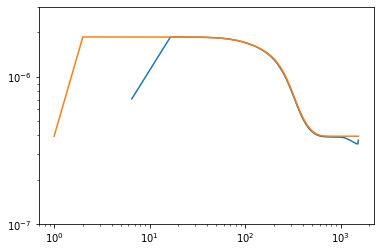

In [15]:
bl = m.biased.pseudocl_lib.b.bin_cell(the.fl)
#plt.loglog(m.ell,delens/bl**2 - (np.radians(2.16/60)**2))
plt.loglog(m.ell,delens)
plt.loglog(the.ell,the.delensed_bb*the.fl**2 +(np.radians(2.16/60)**2) )
plt.ylim(1e-7,3e-6)

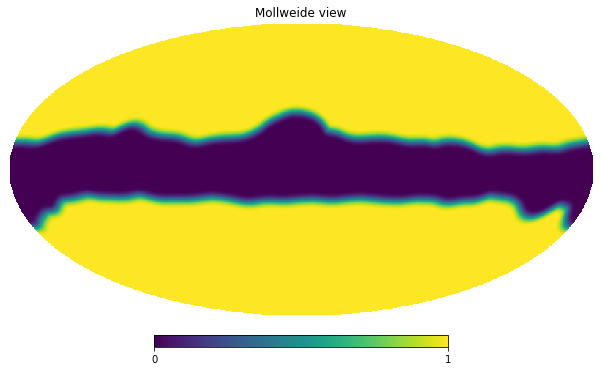

In [16]:
hp.mollview(DC1.pseudocl_lib.mask)

In [17]:
lcov = m.lensed_cov_fid()

Covariance: 100%|██████████| 1000/1000 [00:00<00:00, 226266.60simulation/s]


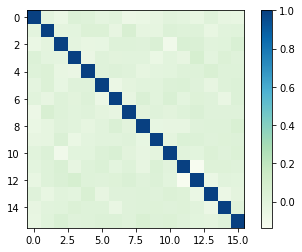

In [18]:
m.plot_corr(lcov)

In [25]:
dcov = m.delensed_cov_fid()

Covariance: 100%|██████████| 1000/1000 [00:00<00:00, 200847.77simulation/s]


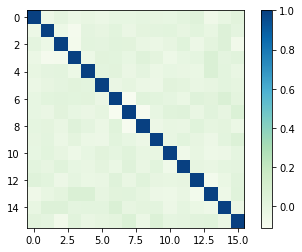

In [20]:
m.plot_corr(dcov)

In [21]:
class LH_base:
    
    def __init__(self,cov,nsample,theory,b,lmin,lmax,which,use_diag):
        self.nsamples = nsample
        self.theory = theory
        self.lensed_bb = self.theory.lensed_bb
        self.delensed_bb = self.theory.delensed_bb
        self.tensor_bb = self.theory.tensor_bb
        self.b = b
        ell = b.get_effective_ells()
        self.select = np.where((ell>lmin) & (ell<lmax))[0]
        self.ell = ell[self.select]
        self.which = which
        
        if use_diag:
            cov_ = np.zeros(cov.shape)
            np.fill_diagonal(cov_, np.diag(cov))
        else:
            cov_ = cov
        self.cov = cov_
        self.cov_inv = np.linalg.inv(cov_) 
    
    def chi_sq(self):
        pass
    
    def cl_theory_lensed(self,r):
        th = (r * self.tensor_bb) + self.lensed_bb
        th = th*self.theory.fl**2 + self.theory.nlevp
        return self.b.bin_cell(th[:self.b.lmax+1])[self.select]
    
    def cl_theory_delensed(self,r):
        th = (r * self.tensor_bb) + self.delensed_bb
        th = th*self.theory.fl**2 + self.theory.nlevp
        return self.b.bin_cell(th[:self.b.lmax+1])[self.select]
    
    def cl_theory(self,r):
        if self.which == 'lensed':
            return self.cl_theory_lensed(r)
        elif  self.which == 'delensed':
            return self.cl_theory_delensed(r)
        else:
            pass
        
        
    def log_prior(self,theta):
        r= theta
        if  -0.5 < r < 0.5:
            return 0.0
        return -np.inf

    def log_probability(self,theta,i):
        lp = self.log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp  -.5*self.chi_sq(theta,i)
    

    def posterior(self,i):
        pos = np.array([0]) + 1e-4 * np.random.randn(100, 1)
        nwalkers, ndim = pos.shape
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.log_probability,kwargs={'i':i})
        sampler.run_mcmc(pos, self.nsamples,progress=True)
        flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
        return flat_samples
    
    def report(self,i):
        samples = i
        cut_samples = samples[samples > 0]
        with suppress_stdout():
            samp = MCSamples(samples=samples,names=['r'], labels=['r'])
            cut_samp = MCSamples(samples=cut_samples,names=['r'], labels=['r'],ranges={'r':(0, None)})
            return f"""full_sample = {samp.getInlineLatex('r',limit=1,err_sig_figs=5)}
            cut_sample = {cut_samp.getInlineLatex('r',limit=1,err_sig_figs=5)}
                    """
        
    def plot_spectra(self,i):
        plt.loglog(self.ell,self.cl_theory_lensed(0),label='theoryL')
        plt.loglog(self.ell,self.cl_theory_delensed(0),label='theoryD')
        plt.errorbar(self.ell,i[self.select],yerr=np.sqrt(np.diag(self.cov)),label='spectra')
        plt.legend()
    
    def plot_posterior(self,i):
        labels = ["r"]

        flat_samples = self.posterior(i)
        print(self.report(flat_samples))
        plt.figure(figsize=(8,8))
        fig = corner.corner(flat_samples, labels=labels,truths=[0] )

In [22]:
class LH_simple(LH_base):

    def __init__(self,cov,nsample,theory,b,lmin=10,lmax=100,which='delensed',use_diag=False):
        super().__init__(cov,nsample,theory,b,lmin,lmax,which,use_diag)
    
    def vect(self,theta,i):
        r = theta
        cl_th = self.cl_theory(r) 

        return cl_th - i[self.select]
    
    def chi_sq(self,theta,i):
        vec = self.vect(theta,i)
        l = np.dot(np.dot(vec,self.cov_inv),vec)
        return  l
    

# class LH_HL(LH_base):
#     def __init__(self,cov,nsample,theory,b,lens_fid,del_fid,lmin=20,lmax=140,which='lensed',use_diag=False):
#         super().__init__(cov,nsample,theory,b,lmin,lmax,which,use_diag)
        
#         if self.which == 'delensed':
#             self.fid = del_fid
#         elif self.which == 'lensed':
#             self.fid = lens_fid
#         else:
#             pass
    
#     def X(self,cl_th,i):
#         return i[self.select]/cl_th

#     def G(self,cl_th,i):
#         x = self.X(cl_th,i)
#         return np.sign(x-1)* np.sqrt(2*(x - np.log(x) - 1))
    
#     def vect(self,theta,i):
#         r = theta
#         cl_th = self.cl_theory(r)
#         g = self.G(cl_th,i)
#         return g*self.fid[self.select]
    
#     def chi_sq(self,theta,i):
#         vec = self.vect(theta,i)
#         l = np.dot(np.dot(vec,self.cov_inv),vec)
#         return  l
    

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 5000/5000 [00:26<00:00, 188.08it/s]


full_sample = r = -0.00001497\pm 0.00045530
            cut_sample = r < 0.000447
                    


<Figure size 576x576 with 0 Axes>

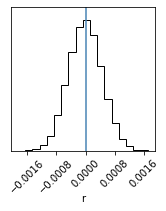

In [23]:
lh = LH_simple(lcov,5000,the,m.biased.pseudocl_lib.b,lmin=20,lmax=180,which='lensed')
lh.plot_posterior(m.get_biased('lensed').mean(axis=0))

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 5000/5000 [00:26<00:00, 190.73it/s]


full_sample = r = -0.00001013\pm 0.00041104
            cut_sample = r < 0.000406
                    


<Figure size 576x576 with 0 Axes>

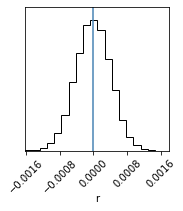

In [26]:
lh = LH_simple(dcov,5000,the,m.biased.pseudocl_lib.b,lmin=20,lmax=180,which='delensed')
lh.plot_posterior(m.get_debiased_extra().mean(axis=0))

In [19]:
lh.plot_posterior(m.get_unbiased('lensed')[1])
#LH_simple(lcov,2000,the,m.biased.pseudocl_lib.b).report(m.get_unbiased('delensed')[0])

100%|██████████| 2000/2000 [00:09<00:00, 202.10it/s]


r = 0.00637865\pm 0.00041615


In [20]:
lens_mean = m.get_biased('lensed').mean(axis=0)
dele_mean = m.get_unbiased('delensed').mean(axis=0)
LH_HL(dcov,2000,the,m.biased.pseudocl_lib.b,lens_mean,dele_mean).plot_posterior(m.get_debiased()[2])

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 2000/2000 [00:13<00:00, 153.09it/s]

r = -0.00050756\pm 0.00036879


In [32]:
1 -(707/771)

0.08300907911802857